In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
import shapely.affinity as shp
import numpy as np 
import matplotlib.ticker as mticker
import matplotlib
from matplotlib import cm

In [2]:
shapename = 'admin_1_states_provinces_lakes_shp' # specified at http://naturalearthdata.com 
states_shp = shapereader.natural_earth(resolution='110m',
                                       category='cultural',
                                       name=shapename)
reader = shapereader.Reader(states_shp)
countries = reader.records() 

In [3]:
df = pd.read_csv("./data/final_loc_data.csv")
pd.to_datetime(df.time)

# find mean values per state 
df_mean = pd.DataFrame(index=df['state'].unique(), columns=df.columns)
for state in df['state'].unique(): 
    df_mean.loc[state,:] = df[df['state'] == state].mean()
    
cmap = matplotlib.cm.get_cmap('bwr')
norm = matplotlib.colors.Normalize( vmin=df_mean['temp'].min(), vmax=df_mean['temp'].max()) 

In [4]:
# create copy where alaska and Hawaii will be moved
df2 = df.copy()  

# original location: 
AKratio = 1
HIratio = 1
AKtrans = [0,0]
HItrans = [0,0]  

In [5]:
# function to move and scale a state
def transform_state( geom, data_frame, trans_x, trans_y, scaling_factor, face_color):
        dataFrame_out = data_frame.copy() 
        geoTrans = shp.translate( geom, trans_x, trans_y)  
        centroid = geoTrans.centroid.coords[0]
        geoTransScale = shp.scale( geoTrans, xfact=scaling_factor, yfact=scaling_factor, origin=centroid)
        ax.add_geometries( geoTransScale, ccrs.PlateCarree(), facecolor=face_color, edgecolor='k')   
        
        dataFrame_out.loc[:,'lon'] = ((data_frame.loc[:,'lon']  - trans_x + centroid[0] )*
                                        scaling_factor  - centroid[0]  )
        dataFrame_out.loc[:,'lat'] = ((data_frame.loc[:,'lat']  + trans_y - centroid[1] )*
                                        scaling_factor  + centroid[1]  ) 
        return dataFrame_out

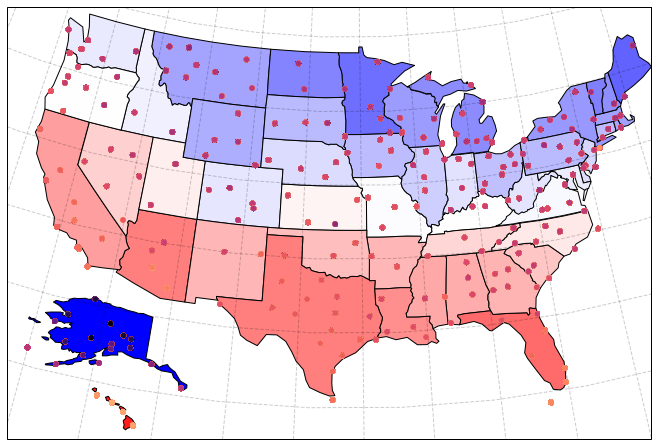

In [15]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())  
ax.set_extent([-160, -75, 21, 70], ccrs.Geodetic())  

# if uncommented, moves Alaska and HawaII closer to the mainland
ax.set_extent([-120, -75, 21, 50], ccrs.Geodetic())    
AKratio = 0.3;  # scales Alaska 
HIratio = 0.7 # scales Hawai 
AKtrans = [38,-36] # moves Alaska south and east 
HItrans = [44,3] # moves Hawaii east and north 
    
for state in shapereader.Reader(states_shp).records():   
    # DC is not in the weather data set, so skip it 
    if state.attributes['name'] =='District of Columbia':  
        continue  

    facecolor = matplotlib.cm.bwr( norm(df_mean.loc[  state.attributes['postal'] ,'temp']) ) 
    
    if  state.attributes['name'] =='Alaska':   
        df_AK = transform_state(state.geometry, 
                                df.loc[df['state']=='AK'], 
                                AKtrans[0], AKtrans[1],
                                AKratio,facecolor)  
        df2.loc[df2['state']=='AK'] = df_AK
    elif  state.attributes['name'] =='Hawaii':   
        df_HI = transform_state(state.geometry, 
                                df.loc[df['state']=='HI'], 
                                HItrans[0], HItrans[1],
                                HIratio,facecolor)  
        df2.loc[df2['state']=='HI'] = df_HI 
    else:  
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='k')
 
ax.scatter( - df2['lon'], df2['lat'], transform=ccrs.PlateCarree(), 
           c=df2['temp'], s=20, cmap='magma',zorder = 10)

gl = ax.gridlines(linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylocator = mticker.FixedLocator(np.arange( 0,90,5))
gl.xlocator = mticker.FixedLocator(np.arange(-220,-20,5))   